In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

sns.set_style()
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Estimación de Insumos en el INT

En este cuadernillo se quieren estimar la cantidad de insumos que necesitará el INT para 2035 considerando su tasa de aumento en cada uno de los diagnósticos más relevantes. Los insumos que se quieren calcular son:

- Camas
- Pabellones
- Procedimientos más importantes (Resonancias, TAC Variadas, Estudios Histopatológicos - Biopsias, etc...)

In [3]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

## Lectura de bases de datos

In [4]:
# Lectura de base DEIS
egresos_torax_deis = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax_deis = egresos_torax_deis[egresos_torax_deis["DIAG1"].isin(DIAGS_RELEVANTES)]
egresos_torax_deis = egresos_torax_deis.drop(
    columns=[
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
)
egresos_torax_deis = egresos_torax_deis.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_deis["dias_en_anio"] = egresos_torax_deis["ANO_EGRESO"].apply(
    build_features.days_in_year
)

# Lectura de base GRD
egresos_torax_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")
egresos_torax_grd = egresos_torax_grd.groupby(["ANO_EGRESO", "DIAG1"]).sum().reset_index()
egresos_torax_grd["dias_en_anio"] = egresos_torax_grd["ANO_EGRESO"].apply(
    build_features.days_in_year
)

## Estimación de Cantidad de Camas

Para estimar la cantidad de camas necesarias se utilizarán los días de estada necesarios para
cada uno de los diagnósticos. Además, se obtendrán los días para cada uno de los años analizados. La fórmula para calcular la cantidad de camas es:

$Cantidad De Camas = \frac{Dias Estada En Periodo}{Cantidad Dias Periodo}$

Por ejemplo:

Si un diangóstico X tiene 2450 Días de Estada en 1 año (no bisiesto), entonces se necesitan la siguiente cantidad de camas para suplir tal diagnóstico:

$Cantidad De Camas = \frac{2450}{365} = 6.7 Camas$

In [5]:
egresos_torax_deis["camas_necesarias"] = (
    egresos_torax_deis["dias_estada_totales"] / egresos_torax_deis["dias_en_anio"]
)
egresos_torax_grd["camas_necesarias"] = (
    egresos_torax_grd["dias_estada"] / egresos_torax_grd["dias_en_anio"]
)

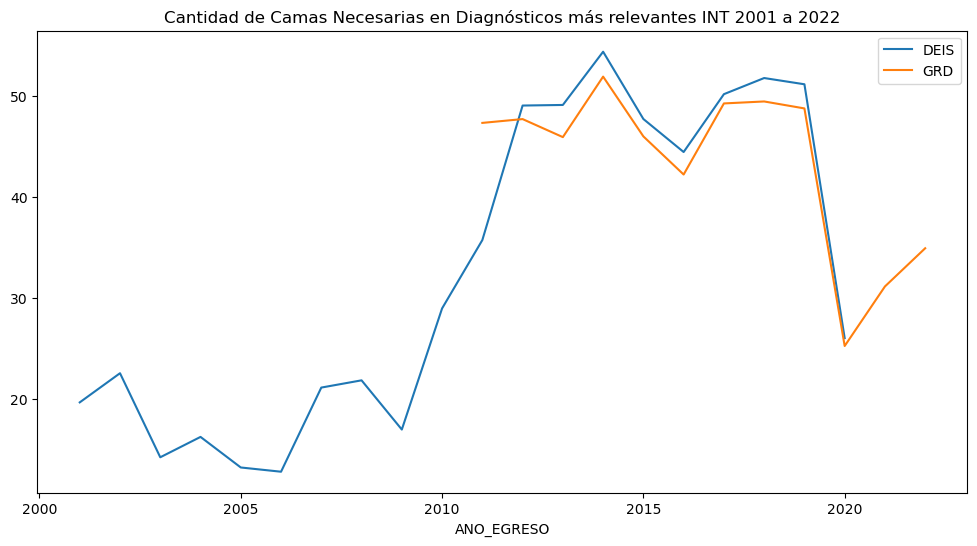

In [6]:
cantidad_camas_deis = egresos_torax_deis.groupby("ANO_EGRESO")["camas_necesarias"].sum()
cantidad_camas_grd = egresos_torax_grd.groupby("ANO_EGRESO")["camas_necesarias"].sum()

fig, axis = plt.subplots()
cantidad_camas_deis.plot(ax=axis, label="DEIS")
cantidad_camas_grd.plot(ax=axis, label="GRD")
plt.legend()
plt.title("Cantidad de Camas Necesarias en Diagnósticos más relevantes INT 2001 a 2022")
plt.show()

Una vez se tiene la necesidad real del INT, es posible calcular la cantidad de camas necesarias con
un aumento en la necesidad. Asumiendo un aumento del 71% de la demanda de los diagnósticos más relevantes en el INT (según modelo de pronóstico), la demanda sería:

In [7]:
AUMENTO_DEMANDA = 1.71

In [8]:
cantidad_camas_deis = cantidad_camas_deis.to_frame()
cantidad_camas_deis["aumento_camas"] = cantidad_camas_deis["camas_necesarias"] * AUMENTO_DEMANDA

cantidad_camas_grd = cantidad_camas_grd.to_frame()
cantidad_camas_grd["aumento_camas"] = cantidad_camas_grd["camas_necesarias"] * AUMENTO_DEMANDA

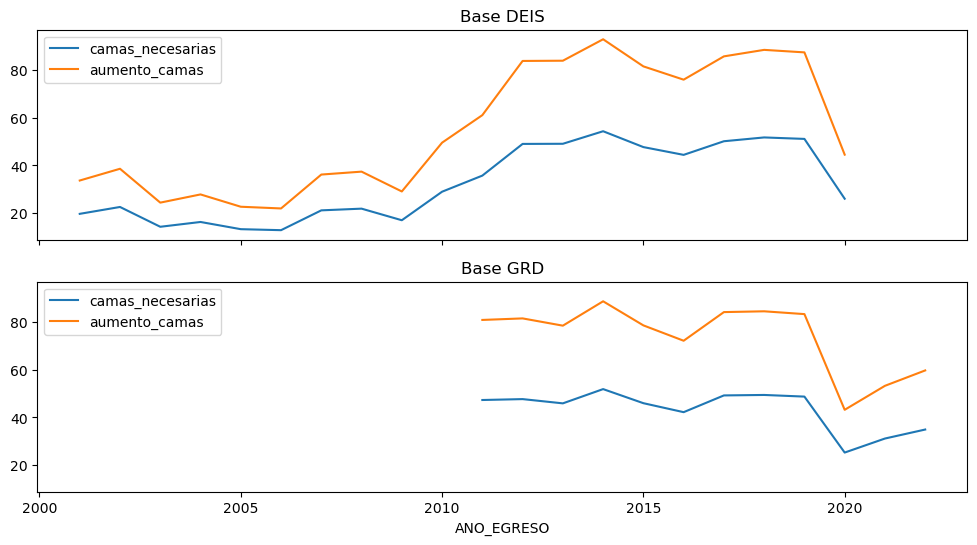

In [9]:
fig, axis = plt.subplots(2, 1, sharey=True, sharex=True)
cantidad_camas_deis.plot(ax=axis[0])
cantidad_camas_grd.plot(ax=axis[1])

axis[0].title.set_text("Base DEIS")
axis[1].title.set_text("Base GRD")
plt.show()

In [10]:
display(cantidad_camas_deis)
display(cantidad_camas_grd)

,camas_necesarias,aumento_camas
ANO_EGRESO,,
2001,19.687671,33.665918
2002,22.569863,38.594466
2003,14.263014,24.389753
2004,16.275956,27.831885
2005,13.254795,22.665699
2006,12.835616,21.948904
2007,21.150685,36.167671
2008,21.866120,37.391066
2009,17.002740,29.074685


,camas_necesarias,aumento_camas
ANO_EGRESO,,
2011,47.304110,80.890027
2012,47.680328,81.533361
2013,45.898630,78.486658
2014,51.876712,88.709178
2015,45.969863,78.608466
2016,42.202186,72.165738
2017,49.227397,84.178849
2018,49.421918,84.511479
2019,48.734247,83.335562


Los resultados indican que el año 2014 fue donde hubo una mayor ocupación de camas por los diagnósticos. Al observar el aumento, se puede ver que aumenta de 54 a 93 camas (aumento de **39 camas**)

## Estimación de Aumento de Procedimientos

Para estimar el aumento de procedimientos, se utilizará la canasta de procedimientos extraída desde
GRD FONASA 2019 a 2021. El análisis consistirá en aumentar proporcionalmente cada una de las
prestaciones necesarias para cada uno de los diagnósticos.

In [25]:
COLUMNAS_A_ELIMINAR = [
    "Código_x",
    "Categoría_x",
    "Sección_x",
    "Capítulo_x",
    "Versión",
    "Código_y",
    "Categoría_y",
    "Sección_y",
    "Capítulo_y",
]

In [26]:
# Lee base de Procedimientos GRD 2019 a 2021
procedimientos_grd = pd.read_excel("../data/processed/canasta_procedimientos_hospitalizados.xlsx")
procedimientos_grd["DIAGNOSTICO1"] = (
    procedimientos_grd["DIAGNOSTICO1"].str.replace(".", "", regex=False).str.ljust(4, "X")
)
procedimientos_grd = procedimientos_grd[procedimientos_grd["DIAGNOSTICO1"].isin(DIAGS_RELEVANTES)]
procedimientos_grd = procedimientos_grd.drop(columns=COLUMNAS_A_ELIMINAR)

Ahora, lo único que debe aumentar en cada uno de los procedimientos es la cantidad de procedimientos
y la cantidad de pacientes distintos. Esto, ya que la proporción de procedimientos_por_pacientes
se debe mantener.

In [30]:
COLUMNAS_A_AUMENTAR_GRD = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

In [39]:
# Aumenta proporcionalmente los procedimientos
aumento_procedimientos_grd = procedimientos_grd.copy()
aumento_procedimientos_grd[
    ["cantidad_procedimientos_aumentados", "cantidad_pacientes_distintos_aumentados"]
] = (aumento_procedimientos_grd[COLUMNAS_A_AUMENTAR_GRD] * AUMENTO_DEMANDA)

Ahora, existen procedimientos de alto interés que se quiere saber su aumento. Estos procedimientos
son:

- Tomografías
- Resonancias Magnéticas
- Biopsias
- Otros...

Por lo tanto, es necesario hacer un resumen de su aumento.

In [47]:
tomografias = aumento_procedimientos_grd[
    aumento_procedimientos_grd["Descripción_x"].str.contains("TOMOGRAFIA")
]
resonancias = aumento_procedimientos_grd[
    aumento_procedimientos_grd["Descripción_x"].str.contains("RESONANCIA MAGNETICA")
]
biopsias = aumento_procedimientos_grd[
    aumento_procedimientos_grd["Descripción_x"].str.contains("BIOPSIA")
]